#### Baby Feed Journal - Preprocessing

### Run Instructions: Run all cells

### >>> Data Cleaning

##### There are multiple errors in the data entry:
###### 1. Some dates are repeated,  but day of week is different. 
##### 2. Wrong day of week

##### Other obstacles: 
##### 1. The date occurs at the end of the activities for most of the data and then at the beginning
##### 2. Blank space between activity and date in one of datapoints
##### 3. Extra '/n' in the data
##### 4. Day of the week, in different formats: Thu, Thur, Thurs
##### 5. Month format is different: Jun, June, 6
##### 6. Other data entry errors: O500 instead of 0500, 155 instead of 15, 20050 instead of 2050

##### ------------------------------------------------------------------------------------------------
##### The goal is to loop through each row of the file, group the data points that occurs between "\n" indicating a day and activity of that day. 

In [83]:
##### Reading the file, splitting the data when next line (\n) is encountered

import pandas as pd
def read_file():
    f = open("baby_feed_journal.txt", "r")
    lines = f.readlines()
    other=[l.split('\n') for l in lines]
    return other

##### Looking for day of the week in the data and appending them to the list that contains action for that day

##### Goal: day will be mapped to the list of activities for the day; [[a1],[a2],[day1]]

In [84]:
result=[]
weekday=""
per_day=[]
other = read_file()
day_of_week=['Thurs','Thur', 'Tues', 'Thus', 'Mon','Tue','Wed','Thu','Fri','Sat','Sun' ]
for item in other[2:]: #ignoring first two lines of data - Baby feeds
  if not item[0] and not item[1]:
    per_day.append([weekday])
    result.append(per_day)
    weekday=""
    per_day=[] 
  elif  any(day1 in item[0] for day1 in day_of_week):
    # print(item)
    weekday=item[0]
  else:
    per_day.append(item)

#### Removing blank spaces (converted '/n') from data

In [85]:
for day in result:
  for action in day:
    if '' in action: 
      action.remove('')
    if not action: 
      day.remove(action)

final_day=[day for day in result if day]

In [86]:
for i in range(0,len(final_day)):
  if (len(final_day[i])<=1):
    if (any(day1 in final_day[i][0][0] for day1 in day_of_week)):
      final_day[i-1].append(final_day[i][0])

##### Removing extra spaces, and '-' from the data

In [87]:
for day in final_day:
  if len(day)<=1:
    final_day.remove(day)
  elif day[0]==['-']:
    day.remove(day[0])
    

##### Mapping day of week to each of the time-action in a day : [day1, activity1], [day1, activity2], acivity = "1253 eat 2oz"

In [88]:
for day in final_day:
  for action in day[:-1]:
    action.insert(0,day[-1][0])
  day.remove(day[-1])

##### Splitting the data into -- Day, time, action:[ [day1, 1253, eat 2oz], [day1, 0830,  pee]]

In [89]:
for day in final_day:
  for action in day:
    act=action.pop()
    time_act=act.split(" ",1)
    action.extend(time_act)

##### Getting data in row-wise format from a list of list format:

In [90]:
final_data=[]
for day in final_day:
  for each_split in day:
    final_data.append(each_split)

##### Creating a Dataframe, removing row that doesn't have time

In [91]:
df = pd.DataFrame(final_data)
#print(df.to_string())
df.columns = ['date','time','action']
print(len(df))
df = df[~df.time.str.contains(r'[^0-9]')]
print(len(df))
df = df.drop_duplicates()
print(len(df))

1663
1659
1655


### Fixing errors in data
##### 1. Changing Month format from name to number
#### 2. Fixing day of the week, changing them to a single format
##### 3. Making day of week a separate column (Column is unneccessary for further analysis)
##### 4. Handling date and time format

In [92]:
from datetime import datetime
date_changes = {'June ':'6/', 'Jun ':'6/', 'July ':'7/', 'Thur':'Thu', 'Thurs':'Thu','Tues':'Tue', 'Thus': 'Thu'}
time_changes = {'O500': '0500', '20050':'2050'}

df['time']= df['time'].replace(time_changes, regex=True)
df['date']= df['date'].replace(date_changes, regex=True)

print(len(df))
df = df.drop_duplicates()
print(len(df))

df['day_of_week'] = df['date'].str.extract("(" + "|".join(day_of_week) +")", expand=False)

f = lambda x: ' '.join([item for item in x.split() if item not in day_of_week])
df['date'] = df['date'].apply(f)
# df['date'].unique()

g = lambda x: datetime.strptime(x, '%m/%d').strftime('%m-%d')
df['date'] = df['date'].apply(g)

time_fmt = lambda t:  datetime.strptime(t, '%H%M').strftime('%H:%M')
df['time'] = df['time'].apply(time_fmt)

print(df.to_string())

1655
1655
       date   time               action day_of_week
0     07-21  12:53             eat 3 oz         Tue
1     07-21  12:48                  pee         Tue
2     07-21  11:35             pee poop         Tue
3     07-21  11:20                 poop         Tue
4     07-21  11:07                  pee         Tue
5     07-21  10:50          eat 2.25 oz         Tue
6     07-21  10:30                 poop         Tue
7     07-21  05:30                  eat         Tue
8     07-21  05:28                  pee         Tue
9     07-21  00:39                  eat         Tue
10    07-20  21:24                  pee         Mon
11    07-20  20:33                  eat         Mon
12    07-20  20:00                  pee         Mon
13    07-20  18:21                  eat         Mon
14    07-20  17:20                  pee         Mon
17    07-20  16:18             eat 2 oz         Mon
18    07-20  16:12                  pee         Mon
19    07-20  15:40             pee poop         Mon
20

##### 1. Checking if action contains 'eat', setting column 'Feed' as True
##### 2. Checking if action contains 'pee, poop', setting column 'Diaper change' as True
#### 3. Extracting hour from time column to group by 'hour' later on

In [93]:
import numpy as np

df['feed'] = np.where((df['action'].str.contains("eat")), 1, 0)
df['diaper_change'] = np.where((df['action'].str.contains("pee")) | (df['action'].str.contains("poop")) , 1, 0)
df['hour'] = df["time"].str[:2]
print(df.to_string())

       date   time               action day_of_week  feed  diaper_change hour
0     07-21  12:53             eat 3 oz         Tue     1              0   12
1     07-21  12:48                  pee         Tue     0              1   12
2     07-21  11:35             pee poop         Tue     0              1   11
3     07-21  11:20                 poop         Tue     0              1   11
4     07-21  11:07                  pee         Tue     0              1   11
5     07-21  10:50          eat 2.25 oz         Tue     1              0   10
6     07-21  10:30                 poop         Tue     0              1   10
7     07-21  05:30                  eat         Tue     1              0   05
8     07-21  05:28                  pee         Tue     0              1   05
9     07-21  00:39                  eat         Tue     1              0   00
10    07-20  21:24                  pee         Mon     0              1   21
11    07-20  20:33                  eat         Mon     1       

##### Finding total number of feed 

In [94]:
def find_total_feeds():
    result = df.feed.value_counts()
    #print(df.feed.value_counts())
    return result[1]

##### Finding total number of diaper changes

In [95]:
def find_total_diaper_changes():
    result = df.diaper_change.value_counts()
    return result[1]

##### Finding total feed and total diaper changes count:

In [96]:
print("total_no_of_feed:"  + str(find_total_feeds()) + '\n')

print("total_no_of_diaper_changes:"  + str(find_total_diaper_changes()))

total_no_of_feed:774

total_no_of_diaper_changes:871


### 5. Graph the number of diaper changes per day over time

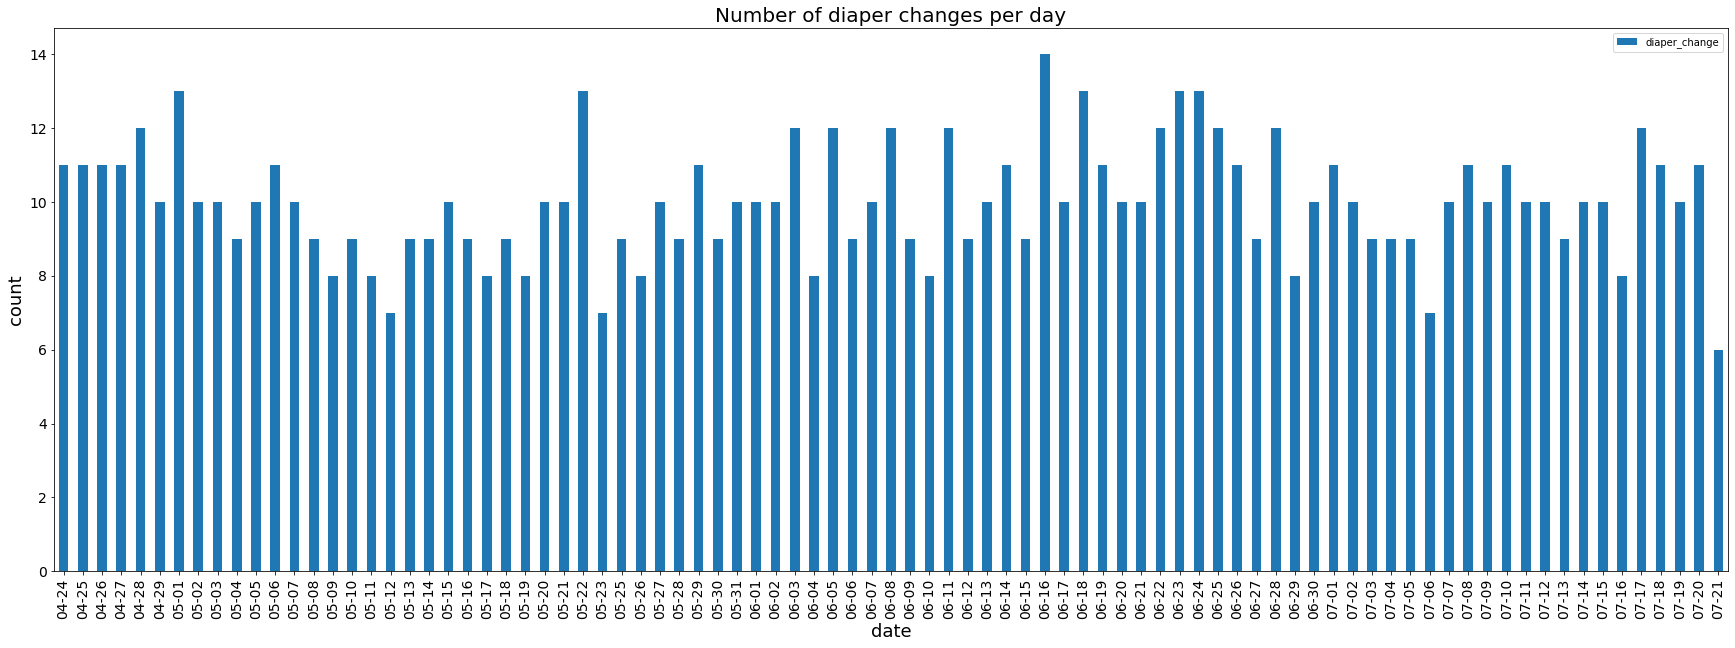

In [97]:
import matplotlib.pyplot as plt

count_df = df.groupby('date', as_index=False).sum()

ax = count_df.plot(kind='bar',x="date", y="diaper_change", figsize=(30, 10), legend=True, fontsize=14)
ax.set_xlabel("date", fontsize=18)
ax.set_ylabel("count", fontsize=18)
ax.set_title("Number of diaper changes per day", fontsize=20)
plt.show()


##### Count action(feed + diaper changes) by hour:

In [98]:
action_by_hour = df.groupby(['date', 'hour']).agg(
         sum_feed = ('feed','sum'),
         sum_diaper_changes = ('diaper_change','sum')).reset_index()

action_by_hour['total_actions'] = action_by_hour['sum_feed'] + action_by_hour['sum_diaper_changes']
print(action_by_hour.to_string())


       date hour  sum_feed  sum_diaper_changes  total_actions
0     04-24   00         0                   1              1
1     04-24   01         1                   0              1
2     04-24   02         1                   0              1
3     04-24   03         0                   1              1
4     04-24   04         0                   1              1
5     04-24   05         1                   0              1
6     04-24   08         1                   1              2
7     04-24   09         0                   1              1
8     04-24   11         1                   1              2
9     04-24   12         0                   1              1
10    04-24   13         1                   1              2
11    04-24   14         1                   0              1
12    04-24   15         0                   1              1
13    04-24   17         1                   0              1
14    04-24   18         0                   1              1
15    04

### 3. Finding day that had the most actions in a given hour:

In [99]:
def find_day_with_most_actions_by_hour():
    most_actions = action_by_hour[['date', 'hour','total_actions']]
    most_actions = most_actions.loc[most_actions.groupby("hour")["total_actions"].idxmax()]

    return most_actions[['date','hour']]

In [100]:
print(find_day_with_most_actions_by_hour())

       date hour
670   06-18   00
257   05-15   01
47    04-27   02
268   05-16   03
234   05-13   04
34    04-26   05
364   05-25   06
76    04-29   07
6     04-24   08
609   06-13   09
718   06-21   10
1038  07-17   11
344   05-22   12
24    04-25   13
93    05-01   14
240   05-13   15
392   05-27   16
264   05-15   17
265   05-15   18
43    04-26   19
859   07-02   20
170   05-07   21
657   06-16   22
60    04-27   23


### 4. Histogram: For all of the days create a histogram to show what hour of the day had the most actions.

In [101]:
def create_histogram():
    histogram_df = action_by_hour
    histogram_df = histogram_df.loc[histogram_df.groupby("date")["total_actions"].idxmax()]
    histogram_df['hour'] = pd.to_numeric(histogram_df['hour'])
    #histogram_df.dtypes
    
    return histogram_df

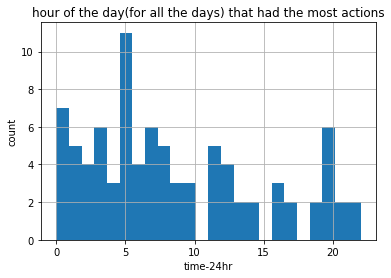

In [102]:
res_df = create_histogram()
vis = res_df.hist('hour', bins=24)

for ax in vis.flatten():
    ax.set_xlabel("time-24hr")
    ax.set_ylabel("count")
    ax.set_title('hour of the day(for all the days) that had the most actions')
plt.show()

### Unit Tests

(As data cleaning part was not done inside a function, there were only few functions to perform Unit Tests)

In [103]:
import unittest

class TestMethods(unittest.TestCase):

    # checking if response from function is Not None
    def test_find_total_diaper_changes(self):
        self.assertNotEqual(find_total_diaper_changes(), None)
        
    #checking if function returns more than 24 rows ( 0-23 hour slots)
    def test_find_day_with_most_actions_by_hour(self):
        self.assertGreaterEqual(len(find_day_with_most_actions_by_hour()), 24)
    
    #checking if Function returns empty dataframe
    def test_create_histogram(self):
        self.assertNotEqual(len(create_histogram()), 0)


In [104]:
TestMethods().test_find_total_diaper_changes()
TestMethods().test_create_histogram()
TestMethods().test_find_day_with_most_actions_by_hour()